In [1]:
import pandas as pd
import numpy as np
import os
import sys
from matplotlib.lines import Line2D
import time
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from utils.utils import *
from segmentation.segmentation import Segmentation
from sklearn import preprocessing
path = '../stats_files/'

In [2]:
dt = DataLoader()
dt.load('../sample_testing/sample2.log')
dt.extractinfo(export=False,single_file=False)

mongodb://localhost:27017/
Database connected


In [60]:
df_rcout = pd.DataFrame(dt.dbconnector.query('CTUN_sample2.log'))

In [61]:
df_rcout.columns

Index(['_id', 'TimeUS', 'ThrIn', 'AngBst', 'ThrOut', 'DAlt', 'Alt', 'BarAlt',
       'DSAlt', 'SAlt', 'DCRt', 'CRt', 'lineIndex'],
      dtype='object')

In [56]:
df_rcout.TimeUS[3437:3458] / 100000000

3437    5.718808
3438    5.719809
3439    5.720807
3440    5.721807
3441    5.722807
3442    5.723807
3443    5.724807
3444    5.725807
3445    5.726807
3446    5.727808
3447    5.728807
3448    5.729817
3449    5.730821
3450    5.731826
3451    5.732833
3452    5.733835
3453    5.734835
3454    5.735841
3455    5.736850
3456    5.737856
3457    5.738864
Name: TimeUS, dtype: float64

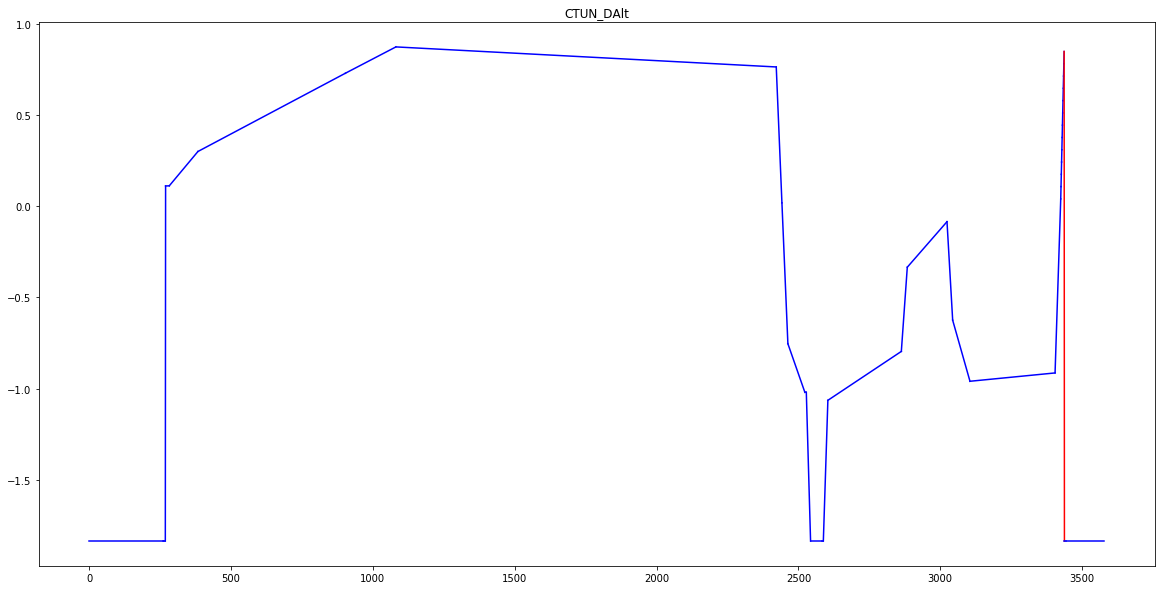

In [65]:
# runvsg = []
fig, ax = plt.subplots(figsize=(20,10))
# for i,gr in enumerate(np.arange(0,2,0.5)):
start_time = time.time()
sg = Segmentation(0.6)
comp ='CTUN'
va = 'DAlt'
fitmethod= 'inter'
sgmethod = 'td'
sr = dt.dbconnector.query(comp+'_sample2.log',va)
sig_length = len(sr)
rng = dt.dbconnector.query(comp+'_sample2.log','lineIndex')
sg.segment(preprocessing.scale(sr),seg_method=sgmethod,fit_method=fitmethod,save_seginstance=False,err_growth=0,batch_size=20)
#print('Signal Run Time: {} , Growth Rate: {}'.format( time.time() - start_time,gr))
#     runvsg.append( time.time() - start_time)
#plt.subplot(2, 2, i+1)
#sg.draw_plot(comp)#+'-'+comp+'_'+va)
rl, idx = sg.find_maxratio()
sg.draw_segments(highlight_idx = idx)
plt.plot()
plt.title(comp+'_'+va)
plt.show()
    #plt.savefig('../report/phase3/'+comp+'_'+va+'_'+sgmethod+'_'+fitmethod+'.png', dpi=500)

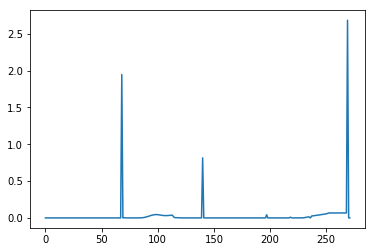

In [23]:
plt.plot(range(len(sg.segments)),rl)

In [64]:
sg.segments[idx]

(3445, 0.006828745043619799, 3462, -1.7303858810591222)

In [ ]:
l = list(np.arange(0,2,0.5))
sns.lineplot(x=l,y=runvsg)
plt.title('Run Time vs Growth Rate')
plt.xlabel('Error Growth Rate')
plt.ylabel('RunTime sec')
plt.show()

In [ ]:
datalist =os.listdir('../data')
#added to the 100 variables
vardict = load_top100_dict()
vardict['RCOU'] = ['RCOU_Ch1','RCOU_Ch2','RCOU_Ccmdh3','RCOU_Ch4']

In [ ]:
dbc = DatabaseConnector('segdb','27017')

In [ ]:
loader = DataLoader()

In [ ]:
existing_collections = dbc.mydb.list_collection_names()
sg = Segmentation(1)
insert_data = True
check_insert =True
normalize = False
batch_size = 70
#------------------------------------------
time_list = []
fitmethod= 'inter'
sgmethod = 'td'
for i,log in enumerate(datalist):
    start_time = time.time()
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    for k,v in vardict.items():
        res = loader.dbconnector.query(k+'_'+log[:-4]) #find signals in the log files 
        if res != -1: #data exists
                df = pd.DataFrame(res)
                df_size = len(df)
                print('Processing Component: {}.. Length: {}'.format(k,df_size))
                if df_size <= 5:
                    continue
#                 if df_size > 2000:
#                         batch_size = batch_size * ((df_size / 2000)/2) #increase the batch size if file is large
                for val in list(set(df.columns).intersection(v)): #loop through the signals
                    cname = 'seg_'+k+'_'+val+'_'+log[:-4]
                    if cname in existing_collections:
                        continue
                    #print('        Signal: {}..'.format(val,df_size))
                    if not np.issubdtype(df[val].dtype, np.number):
                            cat_to_int(df,val)
                    if normalize:
                        srval = preprocessing.scale(df[val])
                    else:
                        srval = df[val]
                    list_segments = sg.segment(srval,seg_method=sgmethod,fit_method=fitmethod,
                                               save_seginstance=False,err_growth =1,batch_size=batch_size)
                    if isinstance(list_segments,int):
                        print('error in segments ', list_segments)
                        continue
                    #export list_segments into a collection
                    if insert_data:
                            if cname not in existing_collections:
                                time_list.append(time.time() - start_time)
                            dbc.set_collection(cname)
                            resp = dbc.insert_dict(pd.DataFrame(list_segments,columns=['x1','y1','x2','y2']).to_dict('list'))
                            if resp == -1:
                                print('Dict insert error in file : {}'.format(log[:-4]))
    print('File Run Time: ', time.time() - start_time)